In [24]:
%load_ext autoreload
%autoreload 2

# DATA MANIPULATION
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# VIEWING OPTIONS IN THE NOTEBOOK
from sklearn import set_config; set_config(display='diagram')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
data = pd.read_csv('../goodtrainbadtrain/data/data_for_model_2.csv')
data['snow'] = data['snow'].replace(np.nan, 0)

data.head()
X = data[['city', 'temp', 'prcp', 'wspd', 'wpgt', 'snow', 'coco', 'weekday', 'month', 'time_of_day']]
y = data['target_numeric']

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

def create_preproc_ordinal():
    feat_ordinal_dict = {
        # considers "missing" as the worse category
        "coco": ['good', 'medium', 'bad', 'extreme']
    }

    feat_ordinal = sorted(feat_ordinal_dict.keys())
    feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

    encoder_ordinal = OrdinalEncoder(
        categories=feat_ordinal_values_sorted,
        handle_unknown="use_encoded_value",
        unknown_value=-1  # Considers unknown values as worse than "missing"
    )

    preproc_ordinal = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        encoder_ordinal,
        MinMaxScaler()
    )

    return preproc_ordinal, feat_ordinal


def create_preproc_numerical():
    return make_pipeline(
        KNNImputer(),
        MinMaxScaler()
    )

def create_preproc_nominal():
    return make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

In [74]:
def create_preproc(X, percentile = 75):
    """Create an (unfitted) sklearn preprocessing pipeline well suited for the Houses Kaggle Competition

    Args:
        X (pandas.DataFrame): Feature matrix
        percentile (float): Percentage of feature to keep after one hot encoding

    Returns:
        sklearn.pipeline.Pipeline: un-fitted preprocessor
    """
    preproc_ordinal, feat_ordinal = create_preproc_ordinal()
    
    preproc_numerical = create_preproc_numerical()
    feat_numerical = sorted(X.select_dtypes(
        include=["int64", "float64"]).columns)
    
    preproc_nominal = create_preproc_nominal()
    feat_nominal = sorted(
        list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))
    
    feature_transformer = ColumnTransformer(
        [
        ("numerical_encoder", preproc_numerical, feat_numerical),
        ("ordinal_encoder", preproc_ordinal, feat_ordinal),
        ("nominal_encoder", preproc_nominal, feat_nominal)
        ],
        remainder="drop")

    feature_selector = SelectPercentile(
        mutual_info_regression,
        percentile=percentile,  # keep the xx% most important features
    )

    preproc = make_pipeline(
        feature_transformer,
        feature_selector
    )
    return preproc

In [75]:
preproc = create_preproc(X_train)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['prcp', 'snow', 'temp',
                                                   'wpgt', 'wspd']),
                                                 ('ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(ca...
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['coco']),
                                                 ('nominal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'month',
                                                   'time_of_day',
                                                   'weekday'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x12e647550>))])

In [76]:
# Fit the preprocessor on the train set
preproc.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['prcp', 'snow', 'temp',
                                                   'wpgt', 'wspd']),
                                                 ('ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(ca...
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['coco']),
                                                 ('nominal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'month',
                                                   'time_of_day',
                                                   'weekday'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x12e647550>))])

In [77]:
# Create the preprocessed versions of X_train and X_val
X_train_preproc = preproc.transform(X_train)
X_val_preproc = preproc.transform(X_val)

# Let's also already create the preprocessed version of X_test for our future predictions
#X_test_preproc = preproc.transform(X_test)

In [78]:
# Shapes before preprocessing
X_train.shape, X_val.shape #X_test.shape

((30059, 10), (6012, 10))

In [79]:
# Shapes after preprocessing
X_train_preproc.shape, X_val_preproc.shape #,X_test_preproc.shape

((30059, 23), (6012, 23))

In [80]:
preproc.get_feature_names_out()

array(['numerical_encoder__prcp', 'numerical_encoder__snow',
       'numerical_encoder__temp', 'numerical_encoder__wpgt',
       'numerical_encoder__wspd', 'ordinal_encoder__coco',
       'nominal_encoder__city_Köln', 'nominal_encoder__city_München',
       'nominal_encoder__month_April', 'nominal_encoder__month_August',
       'nominal_encoder__month_December',
       'nominal_encoder__month_February', 'nominal_encoder__month_June',
       'nominal_encoder__month_May', 'nominal_encoder__month_November',
       'nominal_encoder__month_October',
       'nominal_encoder__month_September',
       'nominal_encoder__time_of_day_evening',
       'nominal_encoder__time_of_day_morning',
       'nominal_encoder__weekday_Friday',
       'nominal_encoder__weekday_Sunday',
       'nominal_encoder__weekday_Thursday',
       'nominal_encoder__weekday_Tuesday'], dtype=object)

In [81]:
from tensorflow.keras import Sequential, layers

def initialize_model(X):

    #################################
    #  1 - Model architecture       #
    #################################
    
    model = Sequential()
    
    # Input Layer
    model.add(layers.Dense(20, activation='relu', input_dim = X.shape[-1]))
    
    # Hidden Layers
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    
    # Predictive Layer
    model.add(layers.Dense(1, activation='linear'))
    
    ##################################
    #  2 - Our recommended compiler  #
    ##################################
    
    model.compile(optimizer='adam',
                  loss='msle')      # directly optimize for the squared log error!
    
    return model

In [82]:
# 1. Initializing a NeuralNet with its architecture and its compilation method
model = initialize_model(X_train_preproc)
model.summary()

# 2. Training the model
epochs = 50
batch_size = 16

history = model.fit(X_train_preproc, 
                    y_train,
                    validation_data = (X_val_preproc, y_val),
                    epochs = epochs,         # Play with this until your validation loss overfit
                    batch_size = batch_size, # Let's keep a small batch size for faster iterations
                    verbose = 1)

# 3. Evaluating the model
res = model.evaluate(X_val_preproc, y_val, verbose = 0)
print(f"RMLSE achieved after {epochs} epochs = {round(res**0.5,3)}")

# 4. Looking at the lowest loss
minimium_rmlse_val = min(history.history['val_loss'])**0.5
optimal_momentum = np.argmin(history.history['val_loss'])

print(f"Lowest RMLSE achieved = {round(minimium_rmlse_val,3)}")
print(f"This was achieved at the epoch number {optimal_momentum}") 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 20)                480       
                                                                 
 dense_21 (Dense)            (None, 15)                315       
                                                                 
 dense_22 (Dense)            (None, 15)                240       
                                                                 
 dense_23 (Dense)            (None, 20)                320       
                                                                 
 dense_24 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,376
Trainable params: 1,376
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1879/1879 [==============================

In [45]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

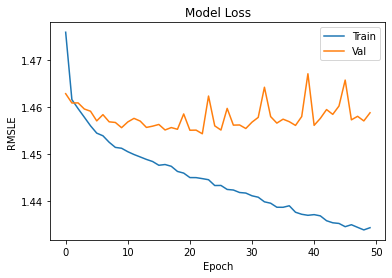

In [83]:
plot_history(history)

# PREDICTION

In [84]:
X_test_preproc = preproc.transform(X_test)
predictions = model.predict(X_test_preproc)

<AxesSubplot:xlabel='target_numeric', ylabel='Count'>

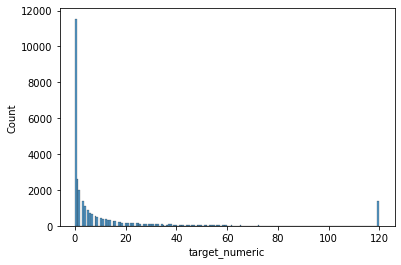

In [67]:
sns.histplot(y_train)

<AxesSubplot:ylabel='Count'>

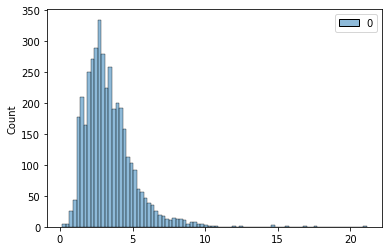

In [86]:
sns.histplot(predictions)

In [64]:
#calculate error of test (unfinished)
pd.DataFrame(predictions, np.array(y_test)).reset_index()

,index,0
0,0,3.751115
1,9,2.680005
2,5,2.469314
3,0,4.324683
4,2,2.083466
...,...,...
4003,1,1.619326
4004,9,2.520641
4005,0,2.439794
4006,1,3.190709
